In [22]:
###########Import required packages###########
import pandas as pd
import numpy as np
import seaborn as sns
import csv as csv
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import  train_test_split, RandomizedSearchCV
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from rfpimp import *
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
sns.set()
%matplotlib inline

In [4]:
###########Load Data###########
train = pd.read_csv('C:/Users/ramak/Downloads/ashrae-energy-prediction/train.csv')
weath_train = pd.read_csv('C:/Users/ramak/Downloads/ashrae-energy-prediction/weather_train.csv')
build_meta = pd.read_csv('C:/Users/ramak/Downloads/ashrae-energy-prediction/building_metadata.csv')

###########Data Preprocessing###########
train.timestamp = pd.to_datetime(train.timestamp)
weath_train.timestamp = pd.to_datetime(weath_train.timestamp)

weath_train['month'] = weath_train['timestamp'].dt.month
weath_train['day'] = weath_train['timestamp'].dt.day
weath_train_togrp = weath_train.drop(['timestamp'], axis=1)
weath_train_daily = weath_train_togrp.groupby(['site_id','month','day']).mean().reset_index()

train['day_of_week'] = train['timestamp'].dt.dayofweek
train['month'] = train['timestamp'].dt.month
train['day'] = train['timestamp'].dt.day
train_togrp = train.drop(['timestamp'], axis=1)
train_daily = train_togrp.groupby(['building_id','meter','month','day']).mean().reset_index()

build_train_merged = pd.merge(build_meta, train_daily, on='building_id', how='inner')
data = pd.merge(build_train_merged, weath_train_daily, on=['site_id','month','day'], how='inner')

Here, we identify columns with nulls. We will not use the year_built and floor_count variables because we are hesitant to impute data for variables where majority of the data is missing.

In [5]:
# To count the NULL/NaN values and drop columns 
len(data) - data.count().sort_values(ascending=True)
percent_missing = data.isnull().sum() * 100 / len(data)
print(percent_missing.sort_values(ascending=False))

floor_count           82.660893
year_built            59.998037
precip_depth_1_hr     13.953158
cloud_coverage         6.957896
sea_level_pressure     4.105943
wind_speed             0.000000
meter                  0.000000
building_id            0.000000
primary_use            0.000000
square_feet            0.000000
day                    0.000000
month                  0.000000
wind_direction         0.000000
meter_reading          0.000000
day_of_week            0.000000
air_temperature        0.000000
dew_temperature        0.000000
site_id                0.000000
dtype: float64


In [ ]:
########### Split Dataset into Train and Test###########
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['meter_reading']), 
                                                    data[['meter_reading']], 
                                                    test_size=0.25, 
                                                    random_state=42, shuffle=True)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((634275, 17), (634275, 1), (211426, 17), (211426, 1))

In [12]:
###########Data Visualization###########
features = ['site_id','building_id','square_feet','meter','month','air_temperature','dew_temperature',
            'wind_speed','cloud_coverage','wind_direction','day','precip_depth_1_hr']

In [13]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
#    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for train dataset', fontsize=15)
    plt.show()

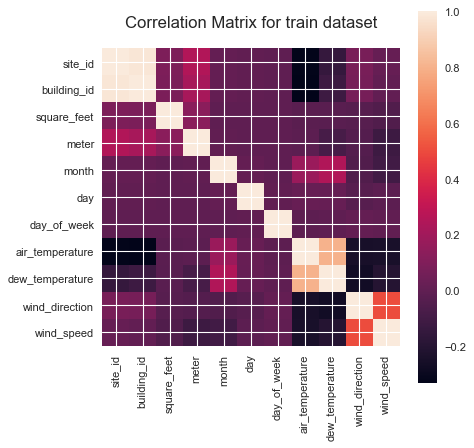

In [14]:
plotCorrelationMatrix(X_train,6)

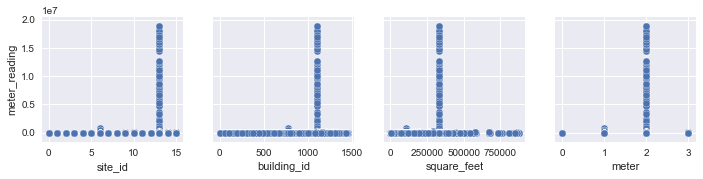

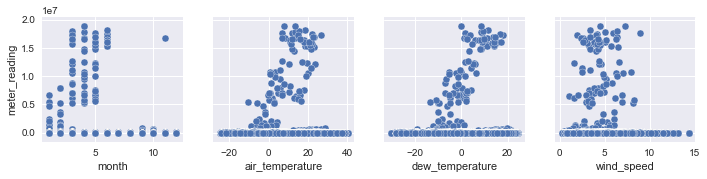

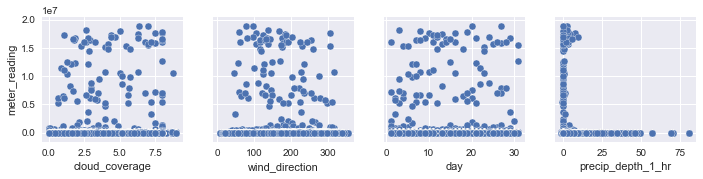

In [15]:
sns.pairplot(pd.concat([X_train,y_train], axis=1), x_vars=features[:4], y_vars='meter_reading')
sns.pairplot(pd.concat([X_train,y_train], axis=1), x_vars=features[4:8], y_vars='meter_reading')
sns.pairplot(pd.concat([X_train,y_train], axis=1), x_vars=features[8:], y_vars='meter_reading')

We will use label encoding technique for the categorical feature primary_use.

In [16]:
le = LabelEncoder()
X_train.primary_use = le.fit_transform(X_train['primary_use'])
X_test.primary_use = le.transform(X_test['primary_use'])

In [17]:
X_train.columns = [col.rstrip('_') for col in X_train.columns] 
X_test.columns = [col.rstrip('_') for col in X_test.columns]

3. XgBoost

This histogram of the target variable clearly shows that its long tailed. Squared error would not be a good loss function.

We want to optimize for the median of the errors since the distribution is long tailed. We will use a Pseudo Huber loss function (shown below), instead of MSE which is very sensitive to outliers.

$L_h(d) = h^2 (\sqrt{1 + (d/h)^2} - 1)$ where $h = 1$

Our implementation was inspired by this stackoverflow post https://stackoverflow.com/questions/45006341/xgboost-how-to-use-mae-as-objective-function, https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn and a github project by samarthinani

In [18]:
def huber_approx_obj(train, preds):
    """
    Function returns gradient and hessein of the Pseudo-Huber function.
    """
    d = preds - train
    h = 1  ## constant
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

In [19]:
## define huber loss - minimizing it means maximizing its negative
def huber_loss(preds, train):
    """Function returns the huber loss for h = 1"""
    d = preds - train
    h = 1
    return -1 * np.sum(np.sqrt(1 + (d/h)**2) - 1)

XgBoost is a very powerful algorithm when it comes to tabular data. Hence we decided to try out the XGBRegressor model.

To find out the optimal hyperparameter combination , we will do a randomized search over a hyper-dimensional space, fitting XgBoost models to minimize the validation Pseudo-Huber loss.

We will be fitting a total of 50 XgBoost models by performing a 5-fold cross validation on the train dataset. This will help us improve the generality of the model.

Lets wrap up all this functionality into a pipeline and conduct a randomized search.

In [20]:
num_features_xgb = ['site_id', 'building_id', 'primary_use', 'square_feet', 'meter', 'month',
                'day', 'air_temperature', 'dew_temperature', 'wind_speed', 'wind_direction',
                'cloud_coverage', 'precip_depth_1_hr']

num_transformer_xgb = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

preprocessor_xgb = ColumnTransformer(transformers=[('num', num_transformer_xgb, num_features_xgb)])

params_xgb = {
    "rcv_xgb__colsample_bytree": uniform(0.7, 0.1),
    "rcv_xgb__gamma": uniform(0, 0.2),
    "rcv_xgb__learning_rate": uniform(0.03, 0.12), 
    "rcv_xgb__subsample": uniform(0.8, 0.15),
    "rcv_xgb__booster": ['gbtree','dart']
}

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor_xgb),
                           ('rcv_xgb', xgb.XGBRegressor(objective=huber_approx_obj, 
                                                        feval= huber_loss, max_depth=5,n_estimators=30))])
search_xgb = RandomizedSearchCV(pipeline_xgb, param_distributions=params_xgb, n_iter=10, 
                            scoring='neg_median_absolute_error', random_state=42, cv=5, 
                            verbose=1, n_jobs=4, return_train_score=True)

In [21]:
%%time
search_xgb.fit(X_train[num_features_xgb], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  9.3min finished


[17:22:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 9min 42s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                     

Evaluation Metrics

In [23]:
def report_best_scores(results, n_top=3):
    """Function gives hyperparameters for the top n models"""
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [24]:
report_best_scores(search_xgb.cv_results_, 3)

Model with rank: 1
Mean validation score: -45.145 (std: 0.660)
Parameters: {'rcv_xgb__booster': 'gbtree', 'rcv_xgb__colsample_bytree': 0.7015966252220214, 'rcv_xgb__gamma': 0.0461787651244298, 'rcv_xgb__learning_rate': 0.0589230559231214, 'rcv_xgb__subsample': 0.9024895278238187}

Model with rank: 2
Mean validation score: -46.281 (std: 1.041)
Parameters: {'rcv_xgb__booster': 'dart', 'rcv_xgb__colsample_bytree': 0.71818249672071, 'rcv_xgb__gamma': 0.03668090197068676, 'rcv_xgb__learning_rate': 0.06650906915514453, 'rcv_xgb__subsample': 0.8787134647448357}

Model with rank: 3
Mean validation score: -47.351 (std: 0.730)
Parameters: {'rcv_xgb__booster': 'dart', 'rcv_xgb__colsample_bytree': 0.7023062425041415, 'rcv_xgb__gamma': 0.10495493205167783, 'rcv_xgb__learning_rate': 0.07798331660583066, 'rcv_xgb__subsample': 0.8069998494820424}



In [25]:
xgb_predictions = search_xgb.predict(X_test)

C:\Users\ramak\Anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


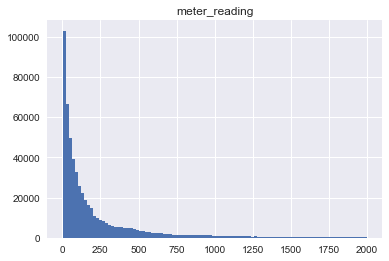

In [26]:
y_train.hist(bins = 100, range = [1,2000]);

Evaluation Metric
A histogram of the target variable is long tailed. We will use the Median Absolute Error as our North Star evaluation metric.

In [27]:
y_train_pred_xgb = search_xgb.predict(X_train[num_features_xgb]) 
y_test_pred_xgb = search_xgb.predict(X_test[num_features_xgb])

In [28]:
train_medae_xgb = median_absolute_error(y_train, y_train_pred_xgb)
test_medae_xgb = median_absolute_error(y_test, y_test_pred_xgb)
print(f'MEDAE XGBoost: Train = {train_medae_xgb:.2f} , Test = {test_medae_xgb:.2f}')

MEDAE XGBoost: Train = 48.85 , Test = 48.66


The XGBoost model, being the most powerful for tabular data, gave us the best test MedAE value of 48.

We also looked at the RMSE and MAE for our reference.

In [30]:
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
print(f'RMSE XGBoost: Train = {train_rmse_xgb:.2f} , Test = {test_rmse_xgb:.2f}')

RMSE XGBoost: Train = 143328.85 , Test = 163963.15


In [31]:
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
print(f'MAE XGBoost: Train = {train_mae_xgb:.2f} , Test = {test_mae_xgb:.2f}')

MAE XGBoost: Train = 1925.08 , Test = 2311.14


In [32]:
train_medae = huber_loss(y_train.values.ravel(), y_train_pred_xgb)
test_medae = huber_loss(y_test.values.ravel(), y_test_pred_xgb)
print(f'Huber Loss XGBoost: Train = {train_medae:.2f} , Test = {test_medae:.2f}')

Huber Loss XGBoost: Train = -1220431598.65 , Test = -488435210.79


Feature Importances

The square feet area of the buidling and its meter type turn out to be two the most important variables

In [34]:
I_xgb = importances(search_xgb.best_estimator_, X_test[num_features_xgb], y_test)

                   Importance
Feature                      
square_feet          0.032611
meter                0.013680
building_id          0.009326
dew_temperature      0.002996
primary_use          0.001694
air_temperature      0.001388
site_id              0.000849
month                0.000502
wind_direction       0.000144
cloud_coverage       0.000122
precip_depth_1_hr    0.000025
day                  0.000003
wind_speed          -0.000006


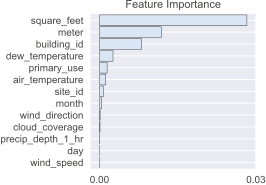

In [35]:
print(I_xgb)
plot_importances(I_xgb,title= 'Feature Importance',imp_range=(0, 0.005))

In [47]:
X_test.reset_index(inplace=True)
X_test['meter_reading'] = xgb_predictions[:,]
sample_submission = X_test[['index','meter_reading']]
sample_submission = sample_submission.rename(columns={"index": "row_id"})

In [60]:
########Predicted Results#########
print(sample_submission)

        row_id  meter_reading
0       397690       3.195448
1        10134       7.183064
2       507036      50.003082
3       529354     159.758743
4        83652      74.276077
...        ...            ...
211421  757243     212.795578
211422  737005     334.716003
211423  807031      30.288240
211424  357673      54.611332
211425  749281     501.934967

[211426 rows x 2 columns]


In [58]:
sample_submission.to_csv('sample_submission.csv')